# AI-Augmented Audit: Exploratory Data Analysis (EDA)

This notebook marks the beginning of our exploratory data analysis on the credit card fraud detection dataset. The primary goal of this phase is to understand the data structure, the distribution of its variables, and to identify the key characteristics of the business problem

## 1. Data Loading and Initial Setup

First, we import the necessary libraries and load the dataset into pandas DataFrame

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/creditcard.csv')

## 2. Target Variable Analysis (Class)

The most critical variable in our project is 'Class', which indicates whether a transaction is normal (0) or fraudulent (1). We will investigate its distribution to understand the nature of the problem.

In [3]:
# Check the distribution of the target variable
print("Class Distribution")
print(df['Class'].value_counts())
print("\n")

# Calculate the percetage of fraudulent transactions
fraud_percentage = (df['Class'].sum() / len(df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")

Class Distribution
Class
0    284315
1       492
Name: count, dtype: int64


Percentage of fraudulent transactions: 0.1727%


### Conclusion: Extreme Class Imbalance

The analisys reveals an extremely imbalanced dataset, with only **0.1727%** of transactions being fraudulent. This introduces the **Acuracy Paradox**: a model that always predicts "normal" would achieve 99.8% accuracy but would be useless in practice, as it would fail to detect any fraud. Let's quantify the financial impact of these fraudulent transactions.

In [4]:
# Calculate the total financial amount of fraudulent transactions
total_fraud_amount = df.loc[df['Class'] == 1, 'Amount'].sum()
print(f"Total amount lost to fraud in this dataset: {total_fraud_amount:,.2f}")

Total amount lost to fraud in this dataset: 60,127.97


## 3. Analysis of the Amount Feature

Next, we'll investigate the distribution of transactions amounts to understand the typical financial behavior of users.

In [5]:
# Statistical summary of the 'Amount' column
print("Statistical Summary of Amount:")
print(df['Amount'].describe())


Statistical Summary of Amount:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


In [6]:
# Sum the 'Value' column where 'Category' is 'A'
df.loc[df['Class'] == 1, 'Amount'].sum()

np.float64(60127.97)

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


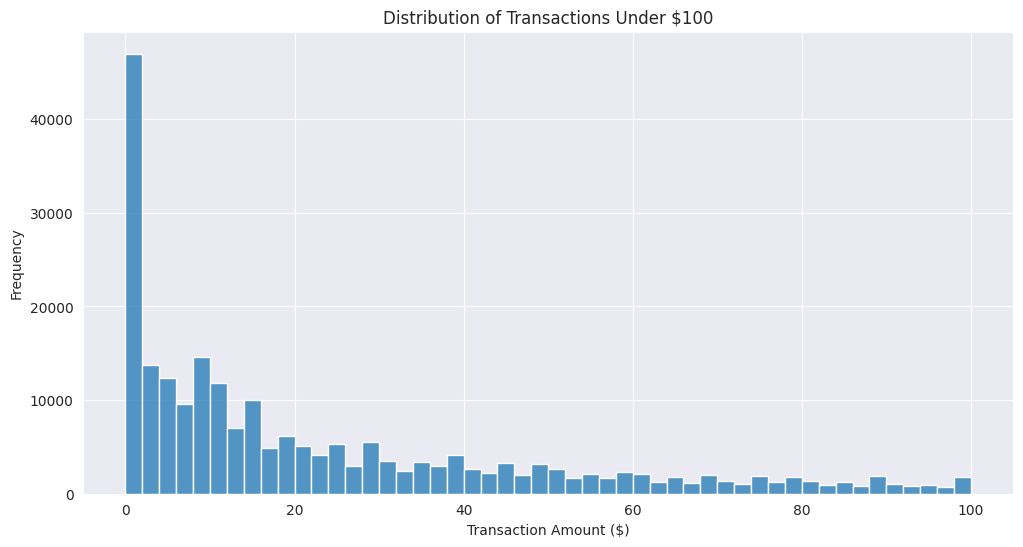

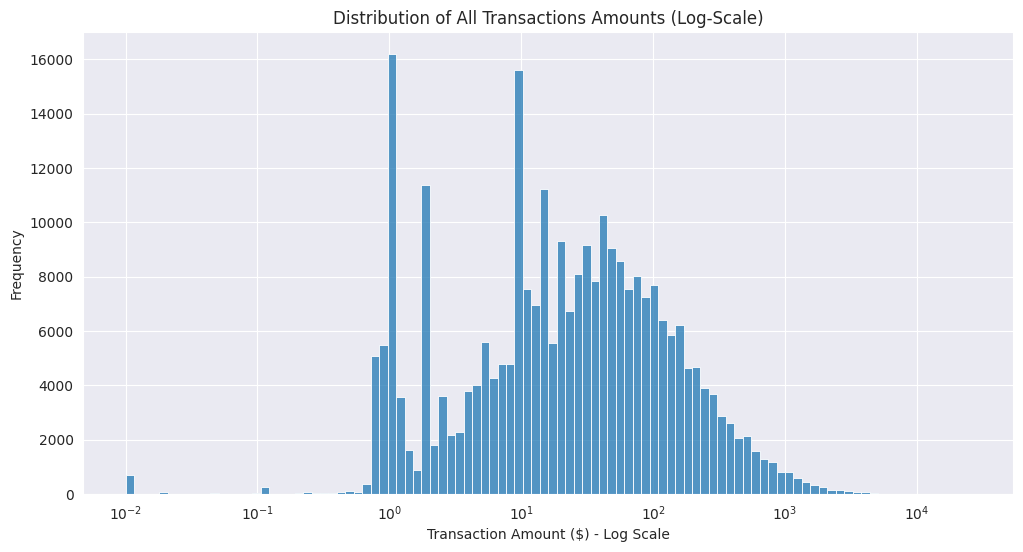

In [7]:
# Descriptive statistics for numerical columns
print(df['Amount'].describe())

# Distribution of transactions under $100
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
# Filtered df
filtered_df = df[df['Amount'] < 100]['Amount']
sns.histplot(data=filtered_df, bins=50)
plt.title("Distribution of Transactions Under $100")
plt.xlabel("Transaction Amount ($)")
plt.ylabel('Frequency')
plt.show()

# Distribution of all transactions (log scale)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Amount', bins=100, log_scale=True)
plt.title("Distribution of All Transactions Amounts (Log-Scale)")
plt.xlabel("Transaction Amount ($) - Log Scale")
plt.ylabel('Frequency')
plt.show()

### Conclusion: `Amount` Distribution

The statistical summary (`mean > median`) and the histograms confirm that the vast majority of transactions are very low value, typically under $20. There are significant outliers with extremely high values, causing strong right-skew in the distribution. The logarithmic scale is essential to visualize the massive concentration of low-value transactions.

## 4. Analisys of the `Time` Feature

Next, we analyze the `Time` feature, which represents the seconds elapsed since the first transaction over 48-hour period.

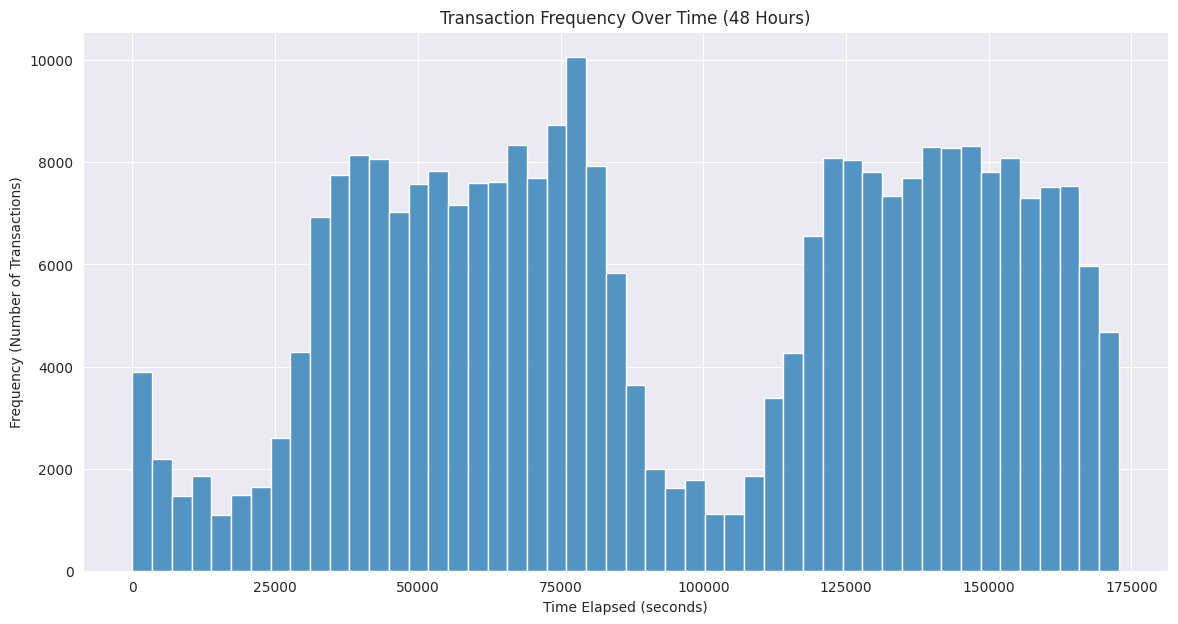

In [8]:
# Set the visual style
sns.set_style('darkgrid')

# Plot the histogram for the `Time` feature
plt.figure(figsize=(14, 7))
sns.histplot(data=df['Time'], bins=50)
plt.title("Transaction Frequency Over Time (48 Hours)")
plt.xlabel("Time Elapsed (seconds)")
plt.ylabel('Frequency (Number of Transactions)')
plt.show()

### Conclusion: `Time` Distribution

The histogram shows a clear pattern for the `Time` feature.

* **"What I See"**: The graph has two big "groups" of activity (peaks) and two very low points (valleys).
* **"What It Means"**: This pattern shows a 48-hour (2-day) cycle. The peaks are the "daytime," when many people are shopping. The valleys are the "nighttime," when most people are asleep.
* **"Why It Matters"**: This is very useful. It means the *time* of a transaction is important. A transaction in the middle of the night (a valley) looks more suspicious than a transaction during the day (a peak). Our next step is to check if the fraud rate is truly higher during the night.

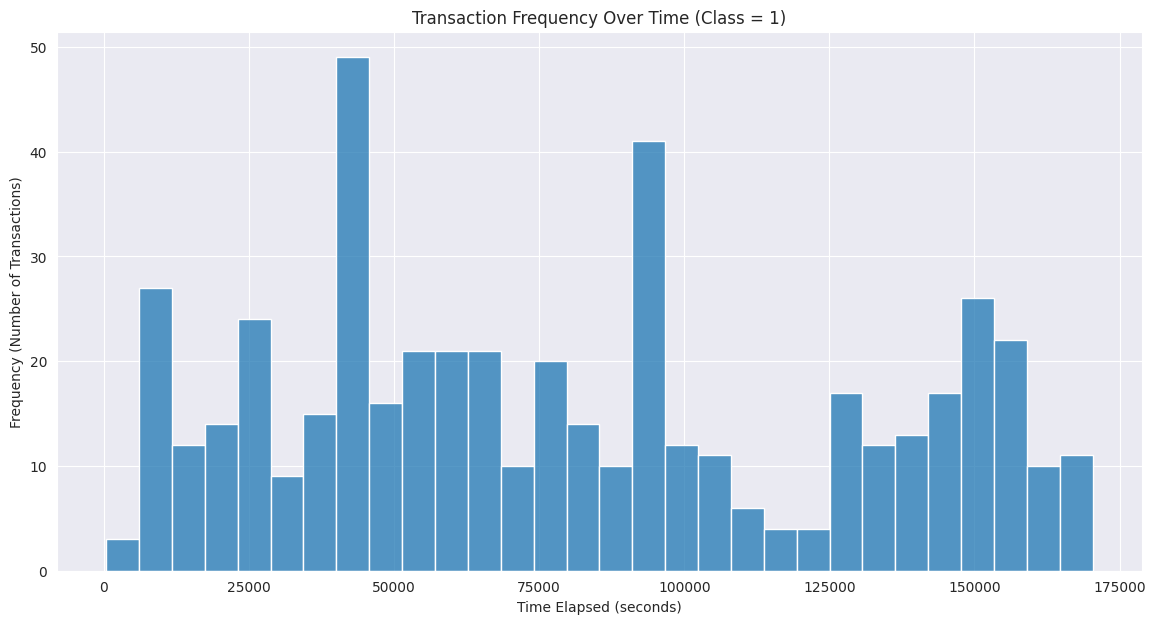

In [9]:
# Set the visual style
sns.set_style('darkgrid')

# Plot the histogram
plt.figure(figsize=(14, 7))
# Filtered df
condition = df[df['Class'] == 1]['Time']
sns.histplot(data=condition, bins=30)
plt.title("Transaction Frequency Over Time (Class = 1)")
plt.xlabel("Time Elapsed (seconds)")
plt.ylabel("Frequency (Number of Transactions)")
plt.show()

### Conclusion: Fraud vs. Time

* **"What I See"**: The "day/night" cycle pattern from the first graph is gone. Fraud transactions are more spread out across all hours.
* **"What It Means"**: This is different from the first "Time" graph. Normal transactions stop at night (the "valleys"). But fraud transactions do not stop.
* **"Why It Matters"**: This is a very strong clue. If a transaction happens at night (in a "valley"), it is very suspicious. Why? Because almost all normal transactions are gone, but the fraud is still active. This means the *chance* of a nighttime transaction being fraud is much higher.

In [10]:
# Define the contitions
conditions = [
    (df['Time'] < 30000), # night1
    (df['Time'] >= 30000) & (df['Time'] < 85000), # day1
    (df['Time'] >= 85000) & (df['Time'] <= 115000), # night2
    (df['Time'] > 115000), # day2
]

# Define the values for each condition (0: night and 1: day)
values = [0, 1, 0, 1]

# Create a new column
df['is_day'] = np.select(conditions, values)

# Print the result
print(df['is_day'].value_counts())

is_day
1    246326
0     38481
Name: count, dtype: int64


In [11]:
df['is_day'].describe()

count    284807.000000
mean          0.864887
std           0.341844
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_day, dtype: float64

In [13]:
# Compute the number of transactions (day and night)
day_transactions = df['is_day'].sum()
night_transactions = len(df) - day_transactions
# print results
print(f"(A): Total Number of Day transactions: {day_transactions:,.0f}") # is_day == 1 (day)
print(f"(B): Total Number of Night Transactions: {night_transactions:,.0f}") # is_day == 0 (night)
print(f"(C): Total Number of Transactions: {len(df):,.0f}")
print(f"(A)/(C) = {day_transactions / len(df) * 100:,.3f}%")
print(f"(B)/(C) = {night_transactions / len(df) * 100:,.3f}%")
print()

# Compute the total amount using a column is_day
amount_day = df.loc[df['is_day'] == 1, 'Amount'].sum()
amount_night = df.loc[df['is_day'] == 0, 'Amount'].sum()
amount_total = df['Amount'].sum()
# Print results
print(f"(D): Total Amount of Day Transactions: {amount_day:,.2f}")
print(f"(E): Total Amount of Night transactions: {amount_night:,.2f}")
print(f"(F): Total Amount (from dataset): {amount_total:,.2f}")
print(f"(D)/(F) = {amount_day / amount_total * 100:,.3f}%")
print(f"(E)/(F) = {amount_night / amount_total * 100:,.3f}%")
print()

# Compute the number of fraud transactions (day and night)
day_fraud_transactions = df.loc[(df['is_day'] == 1) & (df['Class'] == 1)]['is_day'].sum()
night_fraud_transactions = df['Class'].sum() - day_fraud_transactions
# Print Results
print(f"(G): Fraudulent Total of Transactions - Day: {day_fraud_transactions:,.0f}")
print(f"(H): Fraudulent Total of Transactions - Night: {night_fraud_transactions:,.0f}")
print(f"(G) + (H): {day_fraud_transactions + night_fraud_transactions:,.0f}")
print()

# from day transactions & `Class==1`, get the total amount
fraud_day = df.loc[(df['Class'] == 1) & (df['is_day'] == 1), 'Amount'].sum()
# from night transactions & `Class==1`, get the total amount
fraud_night = df.loc[(df['Class'] == 1) & (df['is_day'] == 0), 'Amount'].sum()
# print results
print(f"(G): Total Fraud Amount - Day Transactions: {fraud_day:,.2f}")
print(f"(H): Total Fraud Amount - Night Transactions: {fraud_night:,.2f}")
print(f"(I) = (G) + (H): {fraud_day + fraud_night:,.2f}")

# Compute the proportions
print(f"(G)/(I)Taxa de Fraude - Day: {fraud_day / (fraud_day + fraud_night):,.2f}")
print(f"(H)/(I)Taxa de Fraude - Night: {fraud_night / (fraud_day + fraud_night):,.2f}")

"""
Total Number of Night Transactions: 38,481 que somam $2,508,387.42.
Das 38,481 transacoes noturnas, 170 sao fraudulentas e somama $15,998.39
"""



(A): Total Number of Day transactions: 246,326
(B): Total Number of Night Transactions: 38,481
(C): Total Number of Transactions: 284,807
(A)/(C) = 86.489%
(B)/(C) = 13.511%

(D): Total Amount of Day Transactions: 22,654,202.59
(E): Total Amount of Night transactions: 2,508,387.42
(F): Total Amount (from dataset): 25,162,590.01
(D)/(F) = 90.031%
(E)/(F) = 9.969%

(G): Fraudulent Total of Transactions - Day: 322
(H): Fraudulent Total of Transactions - Night: 170
(G) + (H): 492

(G): Total Fraud Amount - Day Transactions: 44,129.58
(H): Total Fraud Amount - Night Transactions: 15,998.39
(I) = (G) + (H): 60,127.97
(G)/(I)Taxa de Fraude - Day: 0.73
(H)/(I)Taxa de Fraude - Night: 0.27


'\nTotal Number of Night Transactions: 38,481 que somam $2,508,387.42.\nDas 38,481 transacoes noturnas, 170 sao fraudulentas e somama $15,998.39\n'